# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import pickle
import shap
import joblib
from statannot.statannot import add_stat_annotation
from lib.data_load_utils import load_CULPRIT_data, get_data_from_features
from lib.experiment_definitions import get_features


SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


/home/nnieto/Nico/MODS_project/Heart_env/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/nnieto/Nico/MODS_project/Heart_env/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def d

# Figure 1

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `

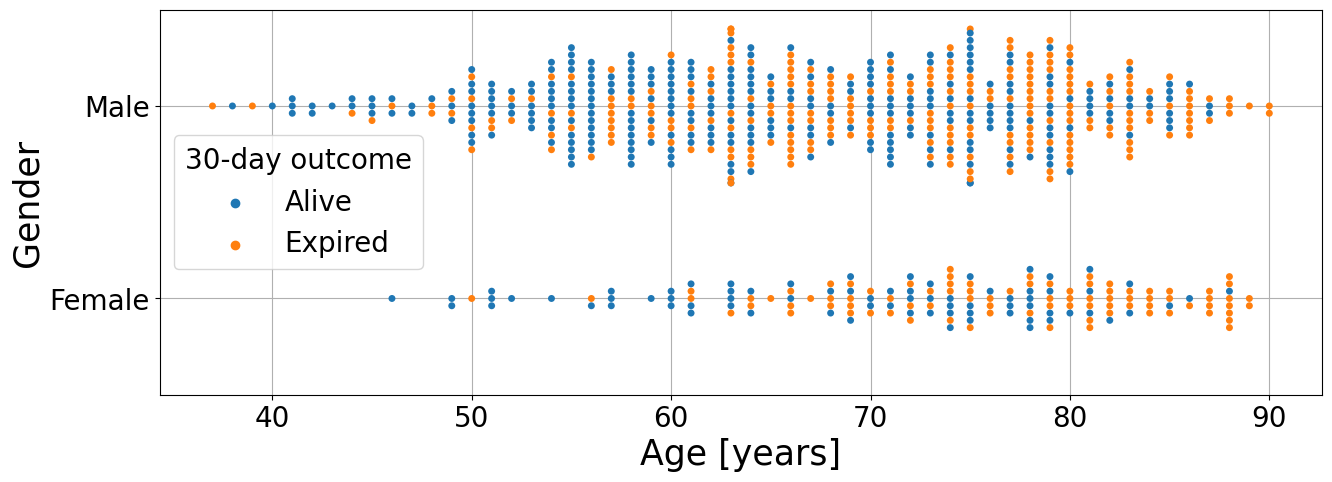

In [31]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/CULPRIT_data/202302_Jung/" # noqa
# endpoint to use
endpoint_to_use = "fu_ce_death_le30d_yn"    # or "fu_ce_death_le365d_yn"

# Get different features depending on the model
# Get all data
patient_info = load_CULPRIT_data(data_dir)
# Set target
y = patient_info.loc[:, ["patient_ID", endpoint_to_use]]


# Extract all the 24hs available features
exp_name = "Admission_v2"
patient_features = get_features(exp_name)

data = get_data_from_features(patient_info, patient_features)


patient_measures = pd.concat([data, y["fu_ce_death_le30d_yn"]], axis=1)

patient_measures.rename(columns={"had_dem_age_yr": "Age"}, inplace=True)

patient_measures.rename(columns={"had_dem_male_yn": "Gender"}, inplace=True)
a = patient_measures["Gender"].unique()
patient_measures["Gender"].replace({1: "Male", 0: "Female", a[2]: "Male"}, inplace=True)
patient_measures.rename(columns={"fu_ce_death_le30d_yn": "30-day outcome"}, inplace=True)
patient_measures["30-day outcome"].replace({1: "Expired", 0: "Alive",}, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=[15, 5])

sns.swarmplot(data=patient_measures, x="Age", hue="30-day outcome",
              ax=ax, y="Gender")
plt.xlabel("Age [years]")
plt.grid(["x"])
plt.ylabel("Gender")
plt.show()

nan

# Fig complementary to Shap Smokers

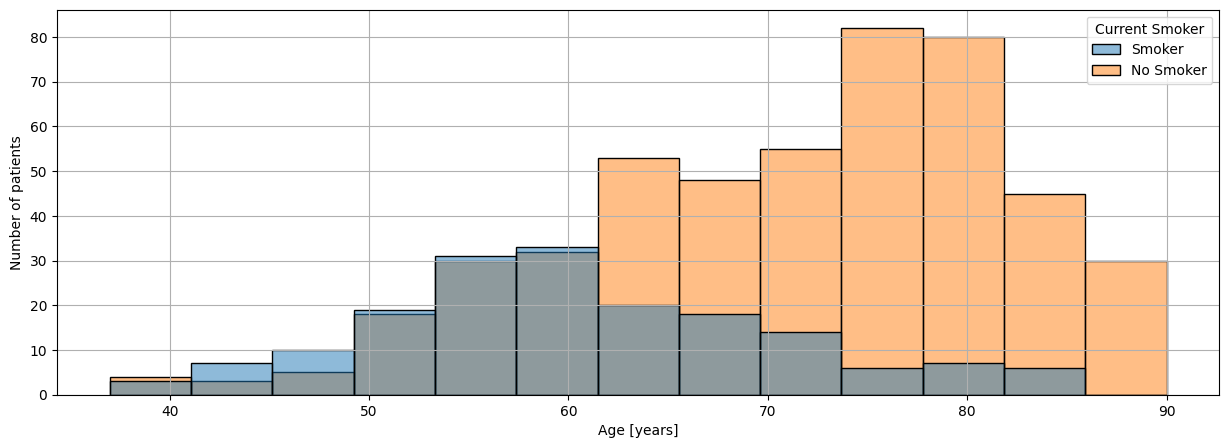

In [6]:
patient_measures.rename(columns={"had_dem_male_yn": "Sex"}, inplace=True)
patient_measures["Sex"].replace({1: "Male", 0: "Female"}, inplace=True)
patient_measures.rename(columns={"p_rf_smoker_yn": "Current Smoker"},
                        inplace=True)

fig, ax = plt.subplots(1, 1, figsize=[15, 5])
patient_measures["Current Smoker"].replace({1: "Smoker", 0: "No Smoker"},
                                           inplace=True)

sns.histplot(data=patient_measures, x="Age", hue="Current Smoker")

plt.xlabel("Age [years]")
plt.grid(["x"])
plt.ylabel("Number of patients")
plt.show()

# Figure 2

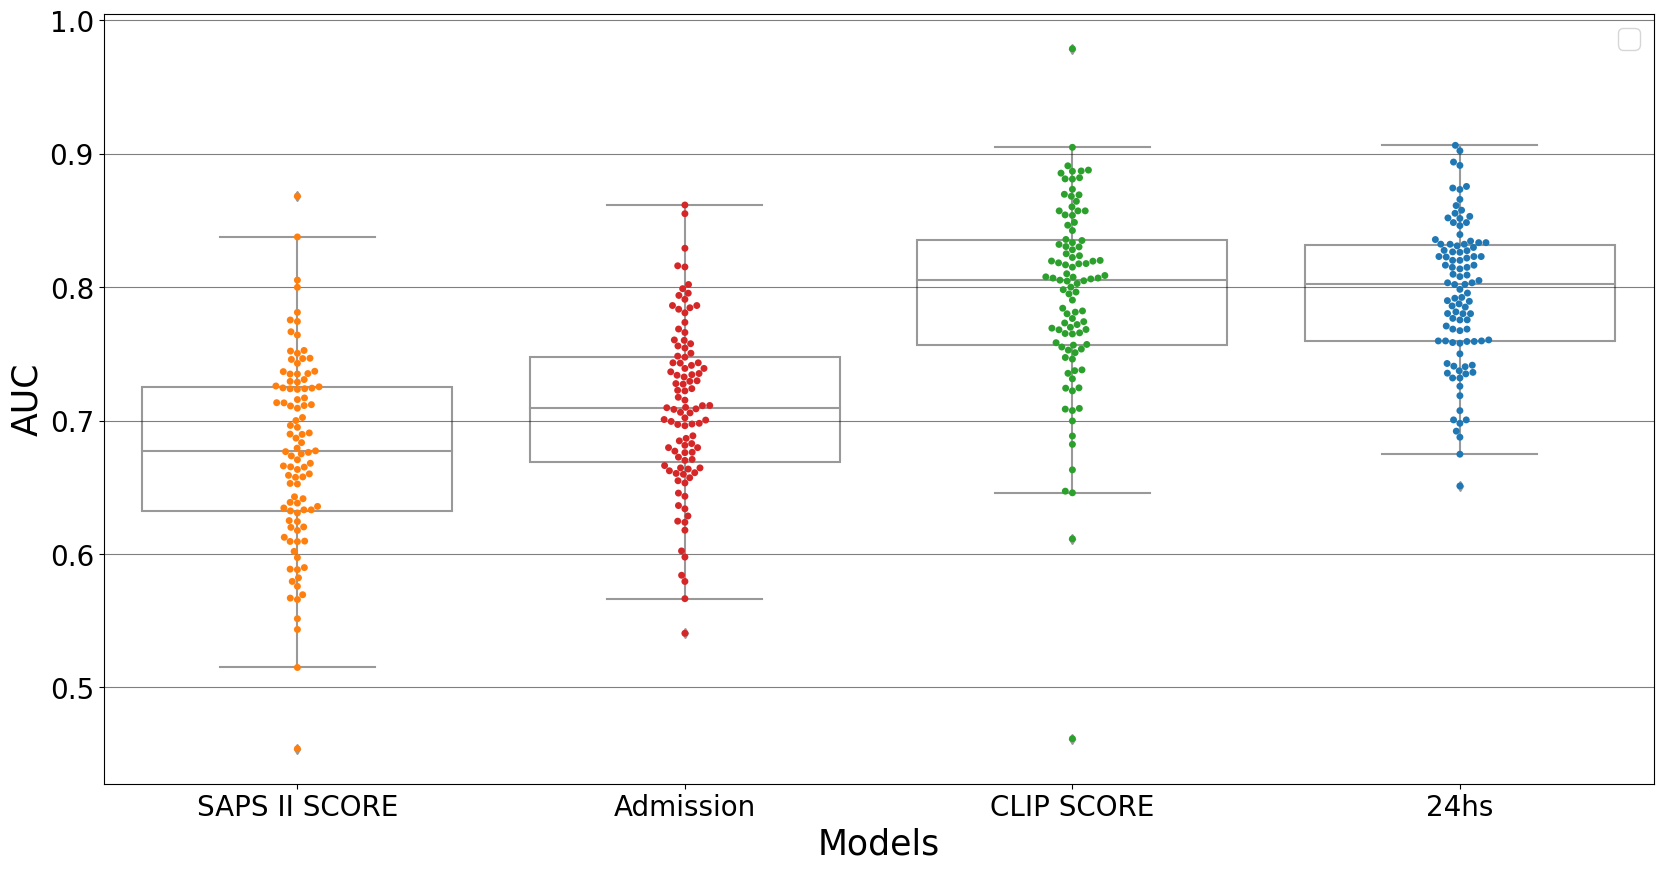

In [12]:
results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/10x10/v2/"
results_scores = pd.read_csv(results_dir + "metrics_10x10_true_and_random_labels_scores_v2.csv")
results_24hs = pd.read_csv(results_dir + "metrics_10x10_true_and_random_labels_24hs_v2.csv")
results_admission = pd.read_csv(results_dir + "metrics_10x10_true_and_random_labels_Admission_v2.csv")

results_df = pd.concat([results_24hs, results_scores, results_admission])
# Change Naming
results_df["Model"].replace({"SAPS_SCORE": "SAPS II SCORE",
                             "CLIP_SCORE": "CLIP SCORE",
                             "IABP_SCORE": "IABP II SCORE"}, inplace=True)

results_true_label = results_df[results_df["Random State"]== False]

metric_to_plot = "AUC"

models_to_plot = [
                "SAPS II SCORE", 
                "Admission",
                "CLIP SCORE",
                "24hs"]

filtered_df = results_true_label[results_true_label['Model'].isin(models_to_plot)]

fig, ax = plt.subplots(1, 1, figsize=[20, 10])

n_models = results_true_label["Model"].nunique()


sns.swarmplot(
    data=filtered_df,
    x="Model", y=metric_to_plot,
    order=models_to_plot, 
    dodge=False, hue="Model", ax=ax,
)

sns.boxplot(
    data=filtered_df, color="w", zorder=1,
    x="Model", y=metric_to_plot,
    order=models_to_plot,
    dodge=True, ax=ax, palette=["w"]*n_models
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:models_to_plot.__len__()], labels[:models_to_plot.__len__()])
ax.legend([])

plt.ylabel(metric_to_plot)
plt.xlabel("Models")
# plt.title(metric_to_plot + " in CULPRIT dataset")
plt.grid(alpha=0.5, axis="y", c="black")
plt.show()

# Figure 4

# OPTUNA

19.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
29.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
29.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
29.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


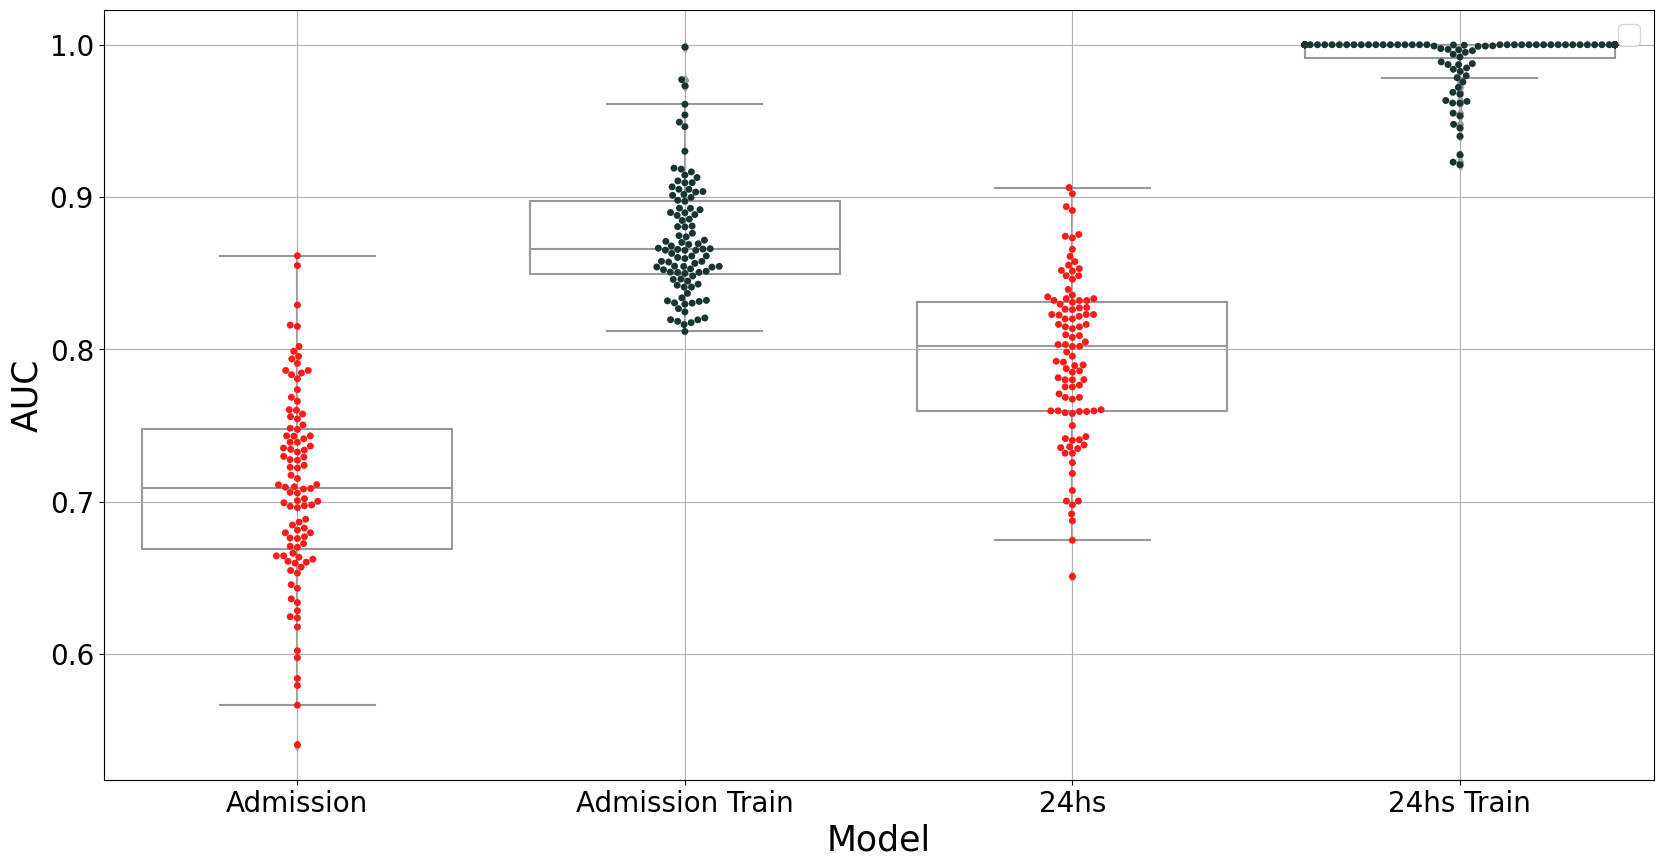

In [21]:
results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/10x10/"
results_24_optuna = pd.read_csv(results_dir + "metrics_10x10_true_and_random_labels_24hs_v2.csv")

results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/10x10/"
results_admission_optuna = pd.read_csv(results_dir + "metrics_10x10_true_and_random_labels_Admission_v2.csv")

results = pd.concat([results_24_optuna, results_admission_optuna])

# 
results_true_label = results[results["Random State"]== False]
results_true_label.replace({"Admission_Train": "Admission Train", "24hs_Train": "24hs Train"}, inplace= True)

metric_to_plot = "AUC"

models_to_plot = [
                "Admission",
                "Admission Train", 
                "24hs",
                "24hs Train", 
                ]

fig, ax = plt.subplots(1, 1, figsize=[20, 10])


sns.swarmplot(
    data=results_true_label,
    x="Model", y=metric_to_plot,
    order=models_to_plot, 
    dodge=False, hue="Model", ax=ax, palette=[[1, 0.1, 0.1],
                                              [0.1, 0.2, 0.2],
                                              [1, 0.1, 0.1],
                                              [0.1, 0.2, 0.2],
                                              ]
)

sns.boxplot(
    data=results_true_label, color="w", zorder=1,
    x="Model", y=metric_to_plot,
    order=models_to_plot,
    dodge=True, ax=ax
)
plt.legend([])
plt.grid()

In [23]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/10x10/"

results_admission = pd.read_csv(data_dir + "metrics_10x10_true_and_random_labels_Admission_v2.csv", index_col=0)
results_24hs = pd.read_csv(data_dir + "metrics_10x10_true_and_random_labels_24hs_v2.csv", index_col=0)
results_df = pd.concat([results_admission,results_24hs])

results_true_label = results_df[results_df["Random State"]== False]


models_to_plot = [
                "24hs",
                  "Admission"
                #   "24hs",
                #   "SAPS II SCORE",
                #   "CLIP SCORE", 
                  ]

metrics = ["Balanced ACC",
           "AUC",
           "F1",
           "Specificity",
           "Sensitivity"]

for model in models_to_plot:
    print(model)
    for metric in metrics:
        results_mean = round(results_true_label[results_true_label["Model"] == model][metric].mean(),3)
        results_std = round(results_true_label[results_true_label["Model"] == model][metric].std(),3)
        confidence_interval = stats.t.interval(0.95, len(results_true_label[results_true_label["Model"] == model][metric]) - 1, loc=results_mean, scale=results_std)

        print(metric + ": " + str(results_mean) + " ["+str(round(confidence_interval[0],3)) + "/" + str(round(confidence_interval[1],3))+"]")


24hs
Balanced ACC: 0.707 [0.59/0.824]
AUC: 0.795 [0.69/0.9]
F1: 0.635 [0.476/0.794]
Specificity: 0.812 [0.701/0.923]
Sensitivity: 0.603 [0.399/0.807]
Admission
Balanced ACC: 0.639 [0.526/0.752]
AUC: 0.709 [0.586/0.832]
F1: 0.609 [0.476/0.742]
Specificity: 0.685 [0.534/0.836]
Sensitivity: 0.593 [0.426/0.76]


# Compar with random distribution

p-value annotation legend:
ns: 1.00e-03 < p <= 1.00e+00
*p<0.001: p <= 1.00e-03

24hs_False v.s. 24hs_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.185e-32 U_stat=9.894e+03
Admission_False v.s. Admission_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.131e-27 U_stat=9.450e+03


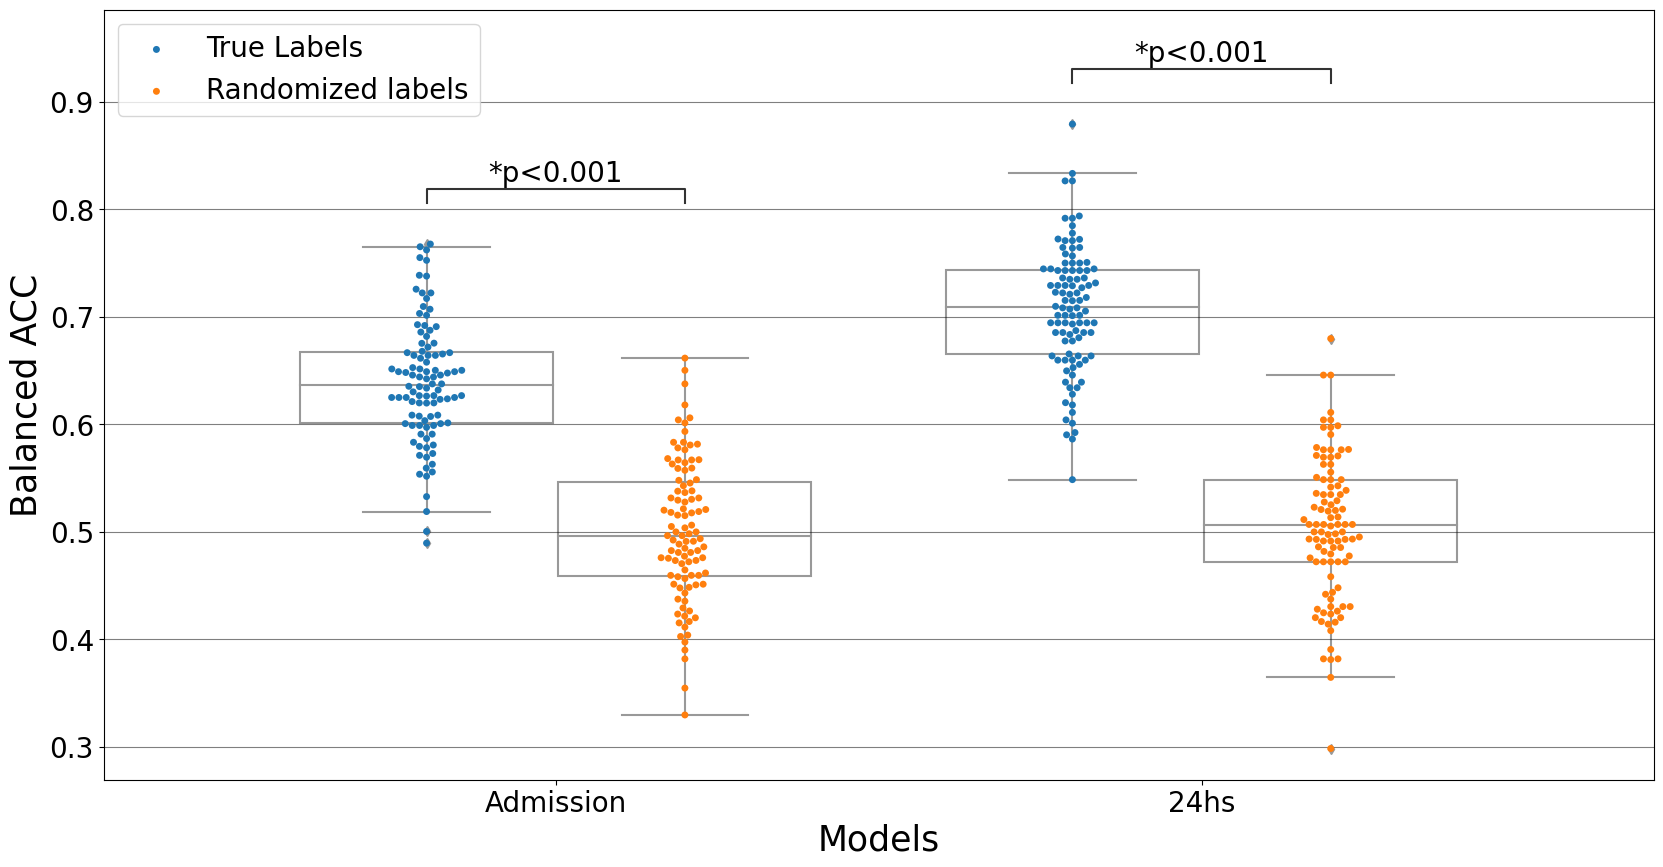

In [34]:
# THE DATA IS SET IN THE PREVIUS CELL
# LOAD DATA FROM RANDOM DISTRIBUTIONS

results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/10x10/v2/"
results_24hs = pd.read_csv(results_dir + "metrics_10x10_true_and_random_labels_24hs_v2.csv")
results_admission = pd.read_csv(results_dir + "metrics_10x10_true_and_random_labels_admission_v2.csv")

results_df = pd.concat([results_24hs, results_admission])
# Change Naming
results_df["Model"].replace({"SAPS_SCORE": "SAPS II SCORE",
                             "CLIP_SCORE": "CLIP SCORE",
                             "IABP_SCORE": "IABP II SCORE"}, inplace=True)

results_false_label = results_df[results_df["Random State"]== True]


# Load OPTUNA DATA
results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/10x10/"
results_24_optuna = pd.read_csv(results_dir + "metrics_10x10_true_and_random_labels_24hs_v2.csv")

results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/10x10/"
results_admission_optuna = pd.read_csv(results_dir + "metrics_10x10_true_and_random_labels_Admission_v2.csv")

results_scores = pd.read_csv(results_dir + "metrics_10x10_true_and_random_labels_scores_v2.csv")

results_df = pd.concat([results_24_optuna, results_admission_optuna, results_scores, results_false_label])

results_df["Model"].replace({"SAPS_SCORE": "SAPS II SCORE",
                             "CLIP_SCORE": "CLIP SCORE",
                             "IABP_SCORE": "IABP II SCORE"}, inplace=True)

models_to_plot = [
    # "SAPS II SCORE",
    "Admission",
    # "CLIP SCORE",
    "24hs", 
]

fig, ax = plt.subplots(1, 1, figsize=[20, 10])
filtered_df = results_df[results_df['Model'].isin(models_to_plot)]

n_models = results_df["Model"].nunique()

metric_to_plot = "Balanced ACC"
metric_to_plot = "Balanced ACC"

sns.swarmplot(
    data=filtered_df,
    x="Model", y=metric_to_plot,
    order=models_to_plot, 
    dodge=True, hue="Random State", ax=ax,
)

sns.boxplot(
    data=filtered_df, color="w", zorder=1,
    x="Model", y=metric_to_plot,
    order=models_to_plot, hue="Random State",
    dodge=True, ax=ax, palette=["w"]*n_models
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:models_to_plot.__len__()], labels[:models_to_plot.__len__()])
ax.legend(["True Labels", "Randomized labels"])



# Comparisons for statistical test
box_list = [(("Admission", True), ("Admission", False)),
            (("24hs", True), ("24hs", False)),
            # (("SAPS II SCORE", True), ("SAPS II SCORE", False)),
            # (("CLIP SCORE", True), ("CLIP SCORE", False))
            ]


add_stat_annotation(ax, data=filtered_df, x="Model", y=metric_to_plot,
                    box_pairs=box_list, test='Mann-Whitney', hue="Random State",
                    text_format='star', loc='inside', order=models_to_plot,
                    verbose=1,
                    pvalue_thresholds=[[1, "ns"], [0.001, "*p<0.001"]])




plt.ylabel(metric_to_plot)
plt.xlabel("Models")
# plt.title(metric_to_plot + " in CULPRIT dataset")
plt.grid(alpha=0.5, axis="y", c="black")
plt.show()

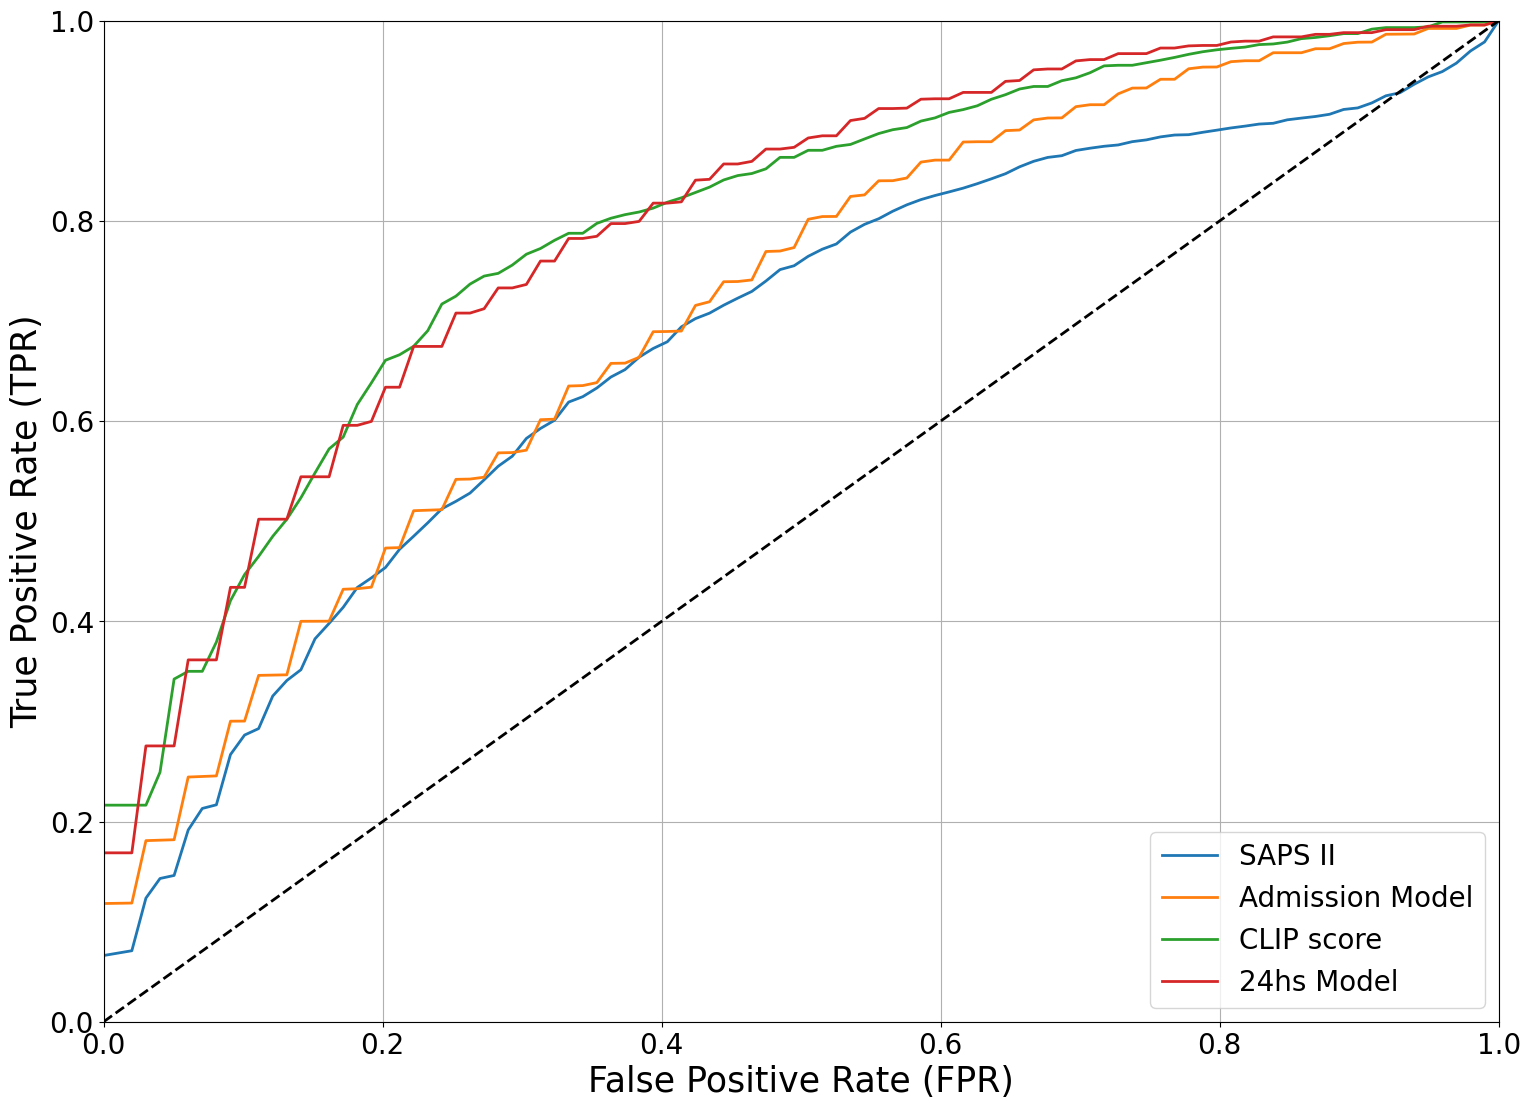

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
import pandas as pd
root_dir_scores = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/predictions/v2/"
root_dir_optuna = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/predictions/"

num_folds = 100
method_names = [["SAPS",root_dir_scores], 
                ["Admission_v2",root_dir_optuna], 
                ["CLIP",root_dir_scores],
                ["24hs_v2",root_dir_optuna]]

all_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(18, 13))

for method_name, root_dir in method_names:
    y_pred_24 = pd.read_csv(root_dir+method_name+"_predictions_for_AUC.csv", index_col=0)
    y_true_all = pd.read_csv(root_dir+"y_true_"+method_name+"_for_AUC.csv", index_col=0)
    # Initialize arrays to store accumulated TPR and FPR values
    mean_tpr = 0

    # Iterate through the folds for the current method
    for fold in y_pred_24.columns:
        y_pred = y_pred_24.loc[:,fold]
        y_pred.dropna(inplace=True)
        y_true = y_true_all.loc[:,str(fold)]
        y_true.dropna(inplace=True)

        # Calculate ROC curve for the current fold
        fpr, tpr, _ = roc_curve(y_true, y_pred)

        # Interpolate the TPR values to match the all_fpr values
        mean_tpr += np.interp(all_fpr, fpr, tpr)

    # Calculate the mean TPR across all folds for the current method
    mean_tpr /= num_folds

    # Calculate the AUC for the average ROC curve of the current method
    mean_auc = auc(all_fpr, mean_tpr)

    # Plot the average ROC curve for the current method
    plt.plot(all_fpr, mean_tpr, lw=2, label=f'{method_name} (AUC = {mean_auc:.2f})')


# Plot the chance level line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance Level')

# Add labels and legend
# plt.title('Average ROC Curve across Folds')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(["SAPS II", "Admission Model", "CLIP score", "24hs Model"],loc='lower right')
plt.grid(True)
plt.xlim([0,1])
plt.ylim([0,1])
SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Show the plot
plt.show()

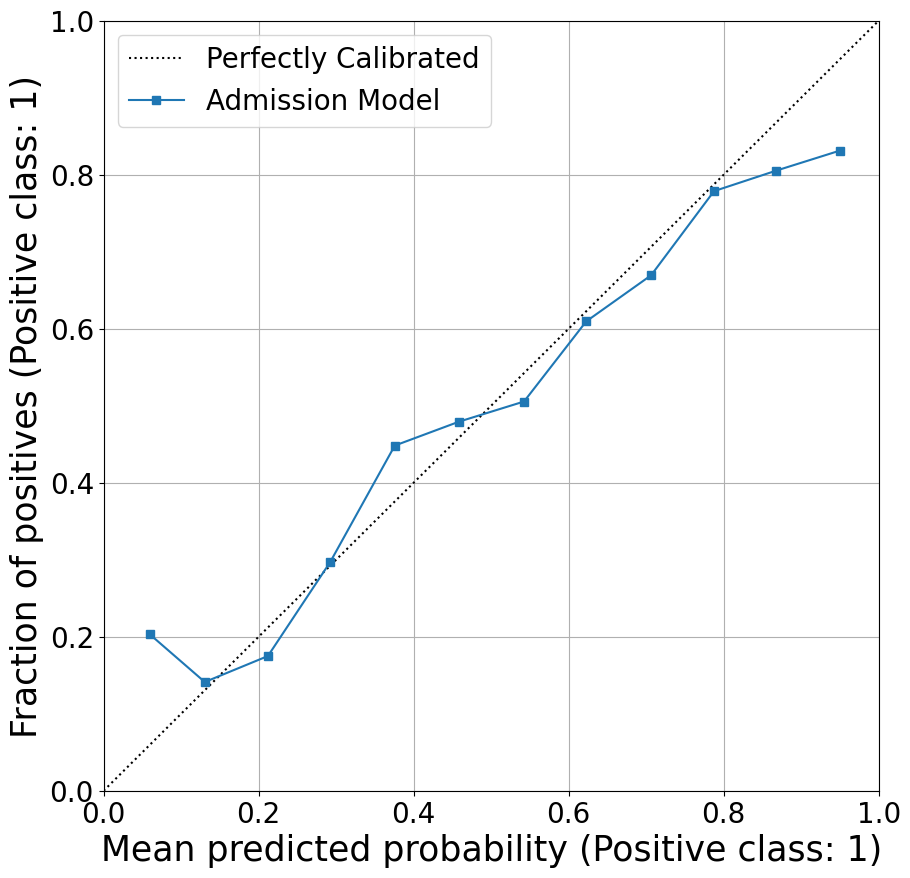

In [2]:
import pandas as pd
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/predictions/"

y_true = pd.read_csv(data_dir +"y_true_Admission_v2_for_AUC.csv", index_col=0)
y_true = y_true.dropna()
y_true = y_true.to_numpy()
y_true = y_true.ravel()

y_pred = pd.read_csv(data_dir +"Admission_v2_predictions_for_AUC.csv", index_col=0)
y_pred = y_pred.dropna()

y_pred = y_pred.to_numpy()
y_pred = y_pred.ravel()

import matplotlib.pyplot as plt

from sklearn.calibration import CalibrationDisplay
n_bins = 12

fig, ax = plt.subplots(1, 1, figsize=[10, 10])
CalibrationDisplay.from_predictions(y_true,
                                    y_pred,
                                    n_bins=n_bins, ax=ax)
# plt.title("Admission model OPTUNA - Calibration Curve")
plt.grid()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(["Perfectly Calibrated", "Admission Model"])

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/predictions/"

y_true = pd.read_csv(data_dir +"y_true_Admission_v2_for_AUC.csv", index_col=0)

y_pred = pd.read_csv(data_dir +"Admission_v2_predictions_for_AUC.csv", index_col=0)


frac_list =[]
calibration_curves = []
n_folds = y_true.shape[1]
for fold in range(10):
    print(fold)
    fold_true = y_true.iloc[:, fold]
    fold_true.dropna(inplace=True)
    fold_pred = y_pred.iloc[:, fold]
    fold_pred.dropna(inplace=True)

    fraction_of_positives, mean_predicted_value = calibration_curve(
        fold_true, fold_pred, n_bins=10, strategy='uniform'
    )
    calibration_curves.append((fraction_of_positives, mean_predicted_value))

# Average calibration curves
avg_fraction_of_positives = np.mean([curve[0] for curve in calibration_curves], axis=0)
avg_mean_predicted_value = np.mean([curve[1] for curve in calibration_curves], axis=0)

# Plot the average calibration curve
plt.figure(figsize=(8, 6))
plt.plot(avg_mean_predicted_value, avg_fraction_of_positives, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly Calibrated')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Average Calibration Curve')
plt.legend()
plt.show()

0
1
2
3
4
5
6
7
8
9


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


ValueError: operands could not be broadcast together with shapes (10,) (5,) 

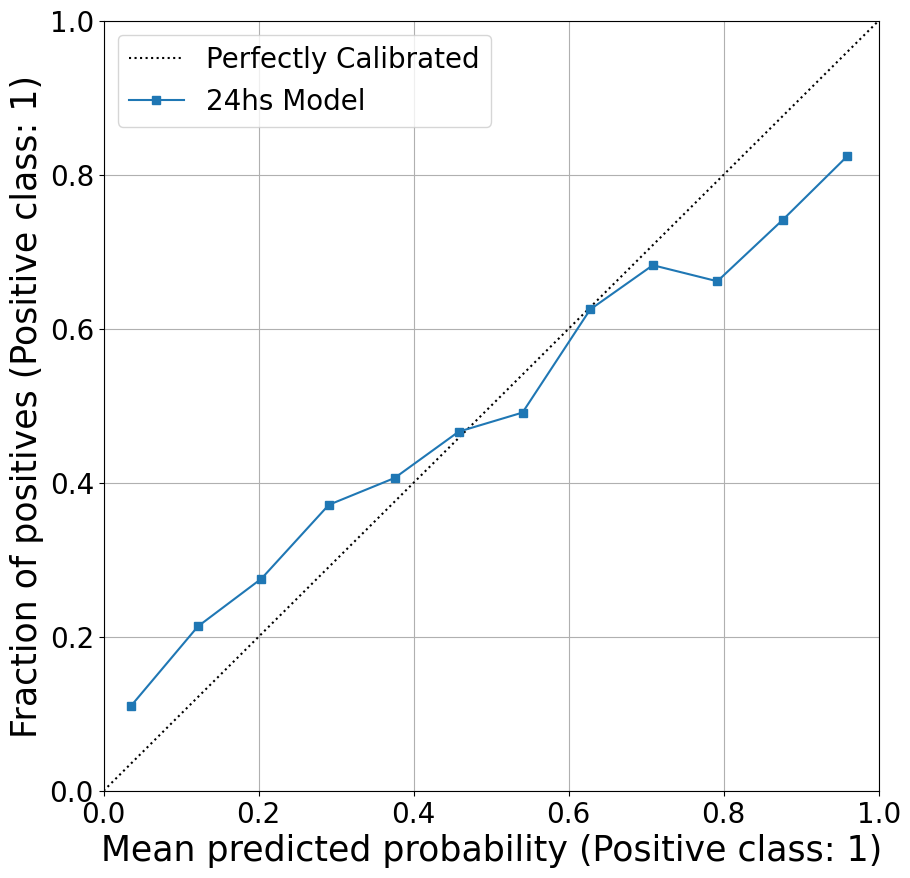

In [8]:
import pandas as pd
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/predictions/"

y_true = pd.read_csv(data_dir +"y_true_24hs_v2_for_AUC.csv", index_col=0)
y_true = y_true.dropna()
y_true = y_true.to_numpy()
y_true = y_true.ravel()

y_pred = pd.read_csv(data_dir +"24hs_v2_predictions_for_AUC_strong.csv", index_col=0)
y_pred = y_pred.dropna()

y_pred = y_pred.to_numpy()
y_pred = y_pred.ravel()

import matplotlib.pyplot as plt

from sklearn.calibration import CalibrationDisplay
n_bins = 12

fig, ax = plt.subplots(1, 1, figsize=[10, 10])
CalibrationDisplay.from_predictions(y_true,
                                    y_pred,
                                    n_bins=n_bins, ax=ax)
# plt.title("24hs model OPTUNA - Calibration Curve")
plt.grid()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(["Perfectly Calibrated", "24hs Model"])

/tmp/ipykernel_116303/867204813.py:28: UserWarning: The label '_none' of <matplotlib.collections.PolyCollection object at 0x7fa67d189a30> starts with '_'. It is thus excluded from the legend.
  plt.legend(["Admission Model", "_none", "24hs Model", "_none", "0.5 Threshold"])
/tmp/ipykernel_116303/867204813.py:28: UserWarning: The label '_none' of <matplotlib.collections.PolyCollection object at 0x7fa67d21cac0> starts with '_'. It is thus excluded from the legend.
  plt.legend(["Admission Model", "_none", "24hs Model", "_none", "0.5 Threshold"])


[]

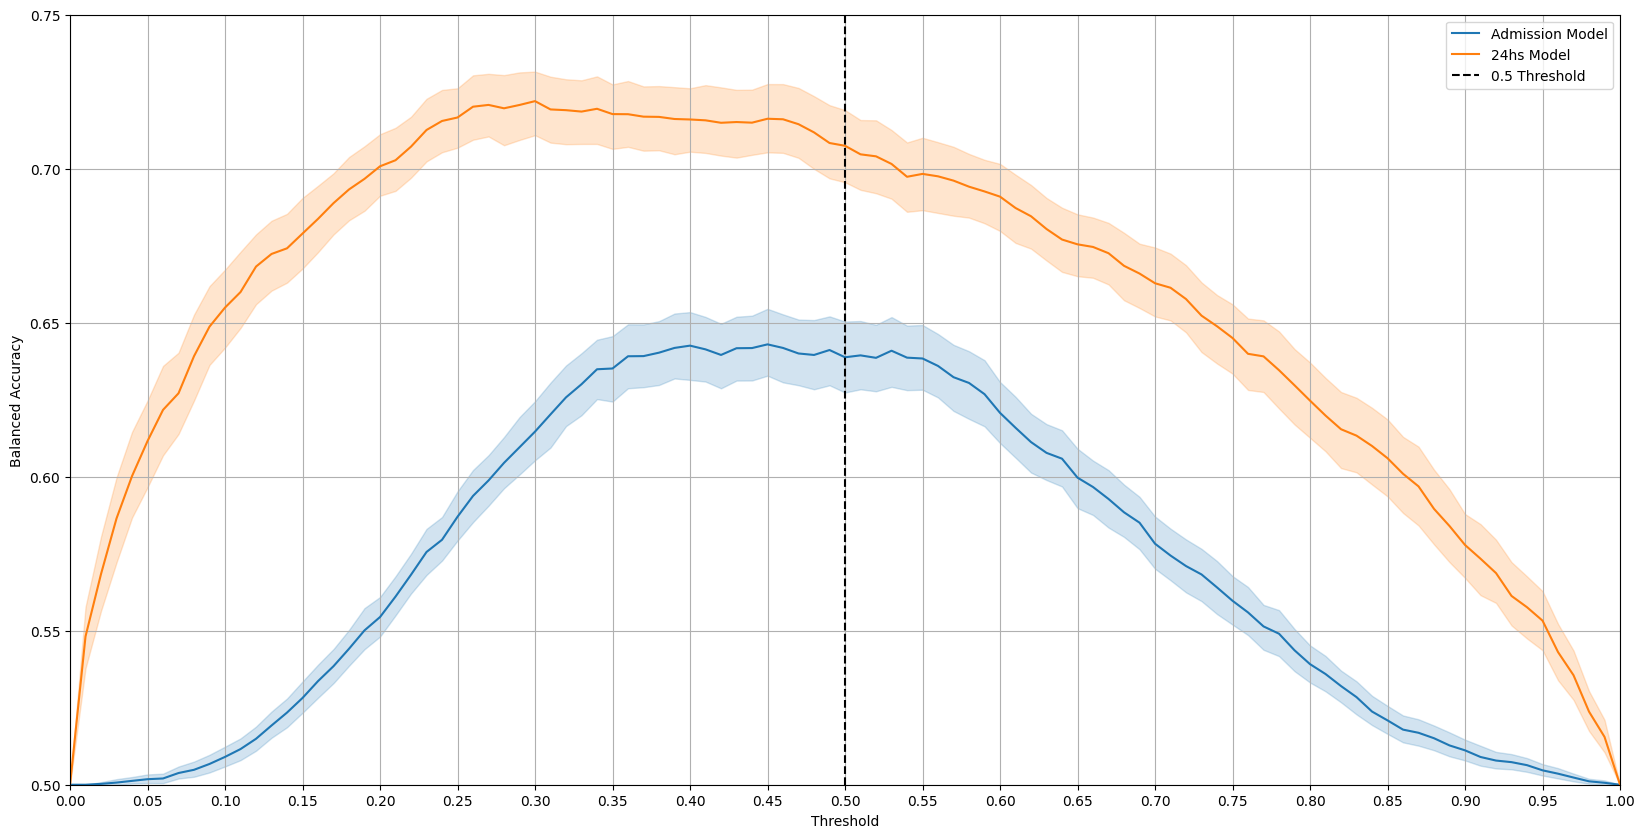

In [41]:
import seaborn as sns
import numpy as np
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/10x10/"
results_ths_admission_df = pd.read_csv(data_dir + "threshold_10x10_Admission_v2.csv")

results_ths_24hs_df = pd.read_csv(data_dir + "threshold_10x10_24hs_v2.csv")
fig, ax = plt.subplots(1, 1, figsize=[20, 10])
metric_to_plot = "Balanced ACC"

model_to_plot = "Admission"
results_ths_df_to_plot = results_ths_admission_df[results_ths_admission_df["Model"] == model_to_plot]   # noqa
sns.lineplot(data=results_ths_df_to_plot, y=metric_to_plot, x="Threshold")
plt.ylabel("Performance")

model_to_plot = "24hs"
results_ths_df_to_plot = results_ths_24hs_df[results_ths_24hs_df["Model"] == model_to_plot]   # noqa
sns.lineplot(data=results_ths_df_to_plot, y=metric_to_plot, x="Threshold")
ths = 0.5

sns.lineplot(x=[ths-.00000001, ths+.00000001], y=[0.50, .8], ax=ax, color="black", linestyle="--", legend=True)
plt.ylim([0.5,0.75])
plt.xlim([0,1])
plt.ylabel("Balanced Accuracy")
plt.title("")
plt.grid()


plt.legend(["Admission Model", "_none", "24hs Model", "_none", "0.5 Threshold"])
custom_ticks = np.arange(0, 1.01, 0.05)  # Range from 0 to 1 with step of 0.1
plt.xticks(custom_ticks)
plt.plot()

# Shap values

## Shap admission

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


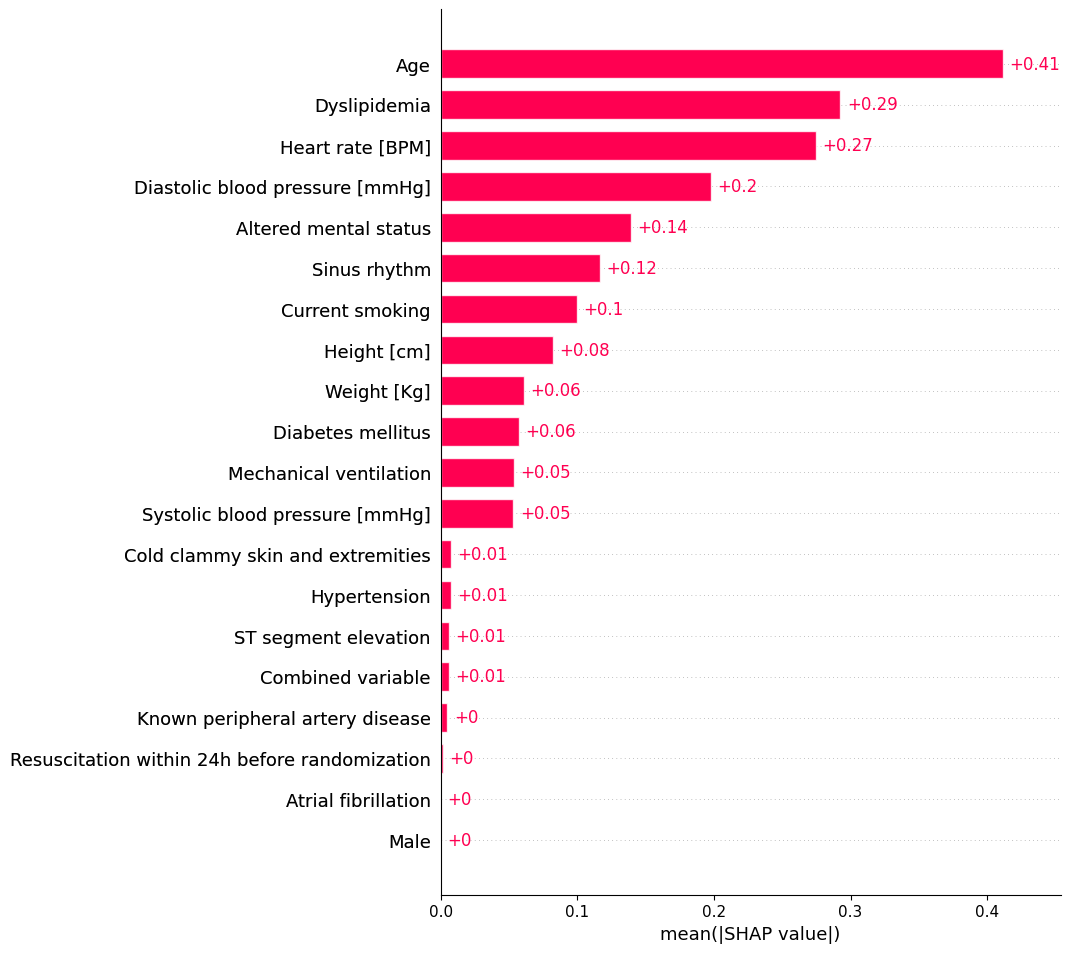

In [2]:

data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/shap_values/"
load_list = ["shap_values_Admission_v2",
             "shap_baselineAdmission_v2",
             "shap_dataAdmission_v2"]
shap_dict = dict()

for file_name in load_list:
    with open(data_dir+file_name, "rb") as fp:
        shap_dict[file_name] = pickle.load(fp)
X_admission = pd.read_csv(data_dir+"X_Admission_v2_v2.csv",index_col=0)


X_admission.rename(columns={"Age_(year)": "Age",
                            "Heart_rate_(bpm)_Hemodinamics": "Heart rate [BPM]",
                            "Diastolic_blood_pressure_(mmHg)_–_HPR":"Diastolic blood pressure [mmHg]",
                            "Height_(cm)": "Height [cm]",
                            "Weight_(kg)": "Weight [Kg]",
                            'Mechanical_ventilation':'Mechanical ventilation',
                            "Resuscitation_within_24h_before_randomization": "Resuscitation within 24h before randomization",
                            "Altered_mental_status": "Altered mental status",
                            "Cold_clammy_skin_and_extremities": "Cold clammy skin and extremities",
                            "combined_variable": "Combined variable",
                            "Previous_congestive_heart_failure": "Previous congestive heart failure",
                            "Previous_stroke": "Previous stroke",
                            "Known_peripheral_artery_disease": "Known peripheral artery disease",
                            "Known_renal_insufficiency_(GFR_less_30_ml/min)": "Known renal insufficiency",
                            "Chronic_dialysis":"Chronic dialysis",
                            "Current_smoking": "Current smoking",
                            "Diabetes_mellitus": "Diabetes mellitus",
                            "Sinus_rhythm": "Sinus rhythm",
                            "Atrial_fibrillation": "Atrial fibrillation",
                            "AV-block_III": "AV block III",
                            'ST-segment_elevation':'ST segment elevation',
                            'Systolic_blood_pressure_(mmHg)_–_HPR':'Systolic blood pressure [mmHg]'}, inplace=True)



model = joblib.load(data_dir+"model_Admission_v2_shap_values.pkl")

explainer = shap.Explainer(model)
shap_values = explainer(X_admission)

shap_values.values = shap_dict["shap_values_Admission_v2"]
shap_values.baseline = shap_dict["shap_baselineAdmission_v2"]
shap_values.data = shap_dict["shap_dataAdmission_v2"]
shap.plots.bar(shap_values, max_display=28)

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


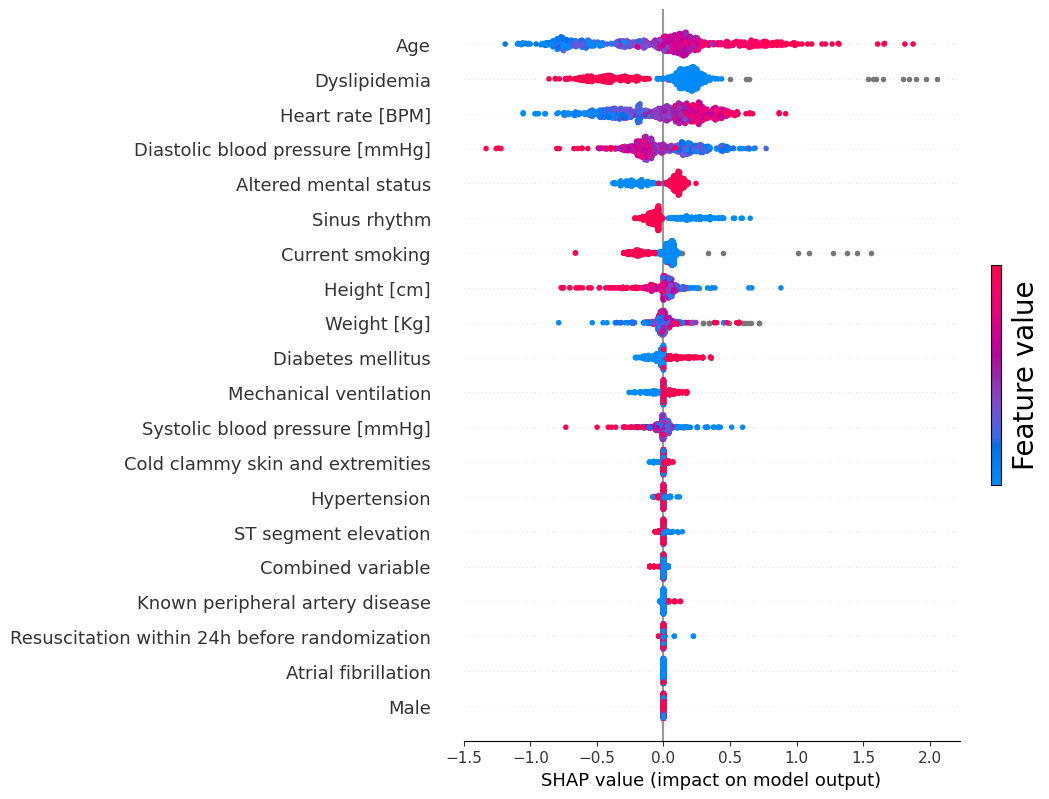

In [3]:
# beeswarm
SMALL_SIZE = 10
MEDIUM_SIZE = 20
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
shap.plots.beeswarm(shap_values, color_bar=False, max_display=50, show=False)
plt.colorbar(location="right",label="Feature value", ticks=[], shrink=0.3)

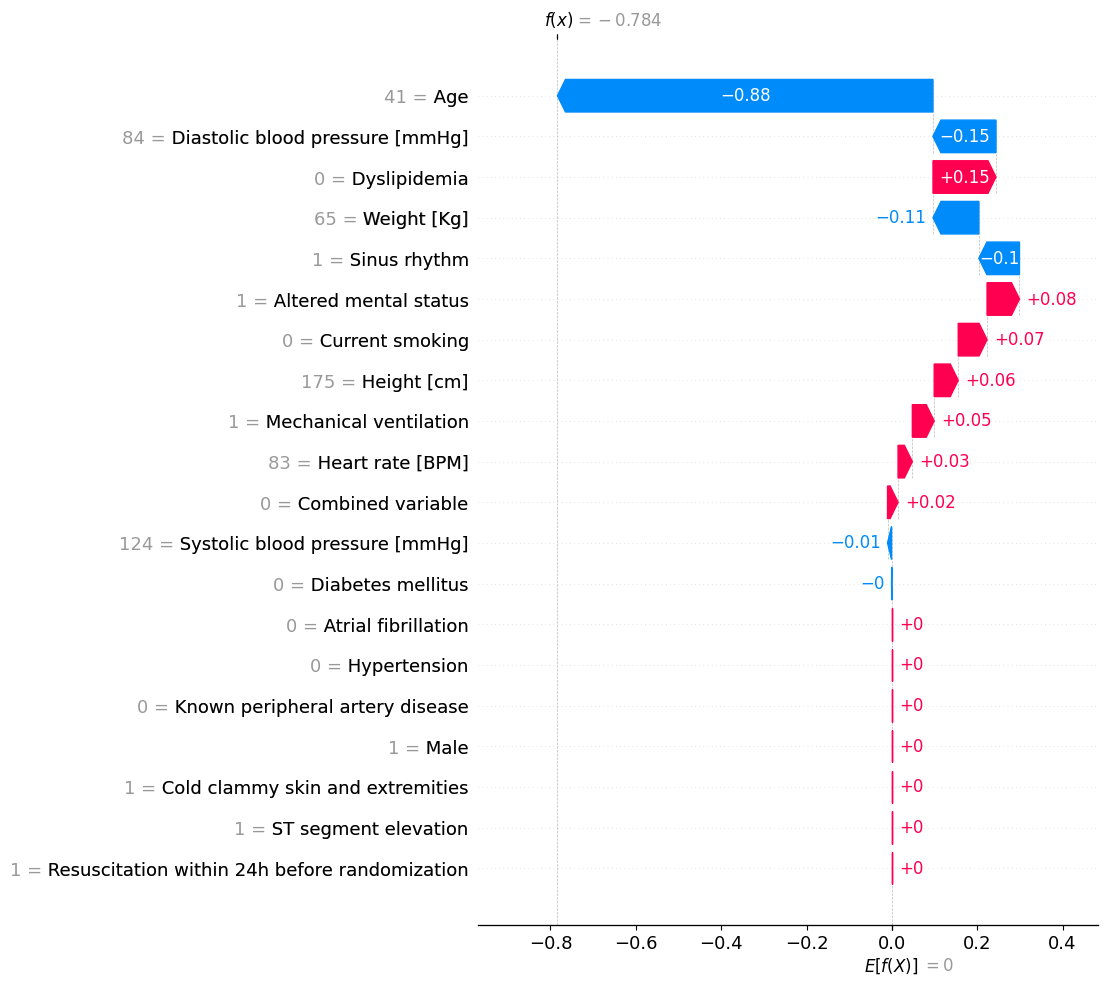

In [4]:
shap_values.base_values = 0
shap.plots.waterfall(shap_values[11], max_display=20)

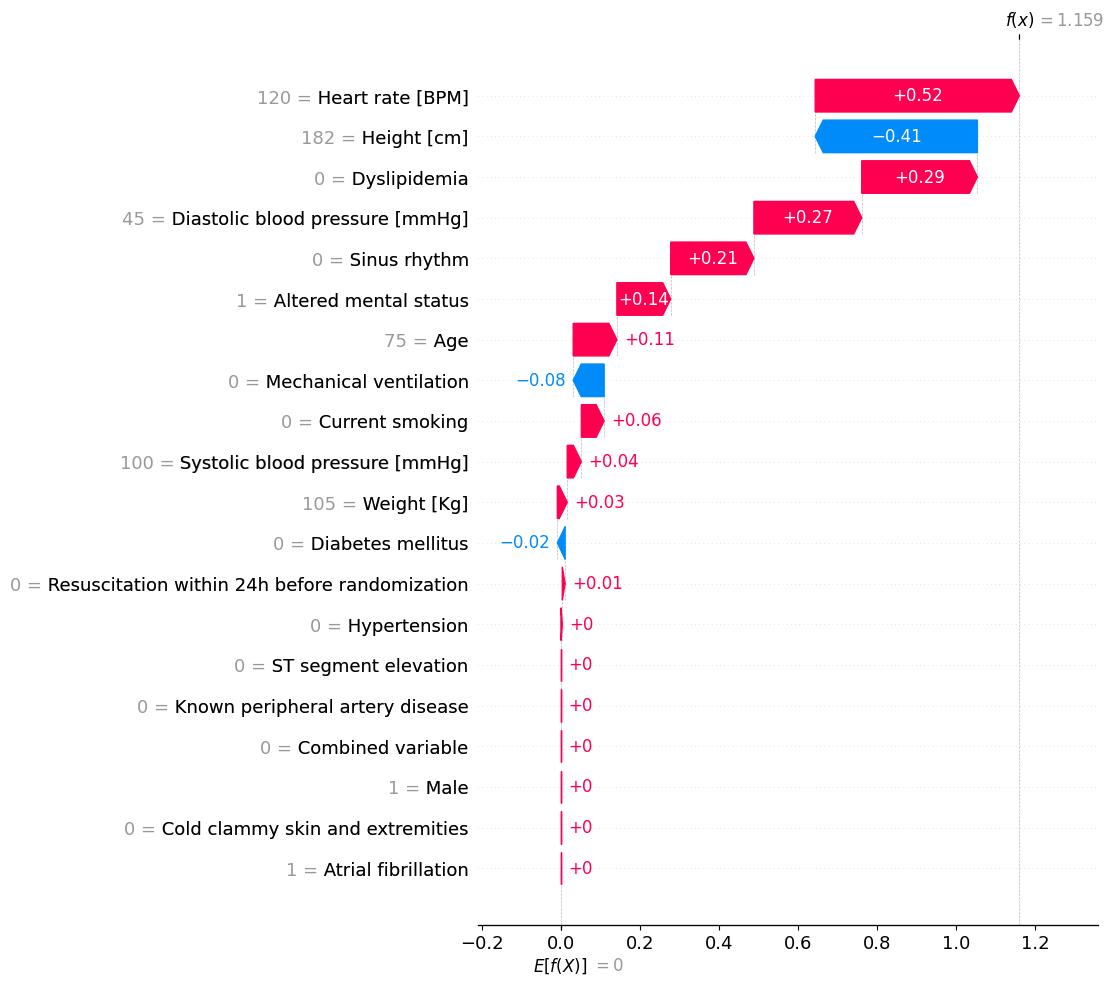

In [5]:
shap.plots.waterfall(shap_values[67], max_display=20)

## Shap for 24hs model

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


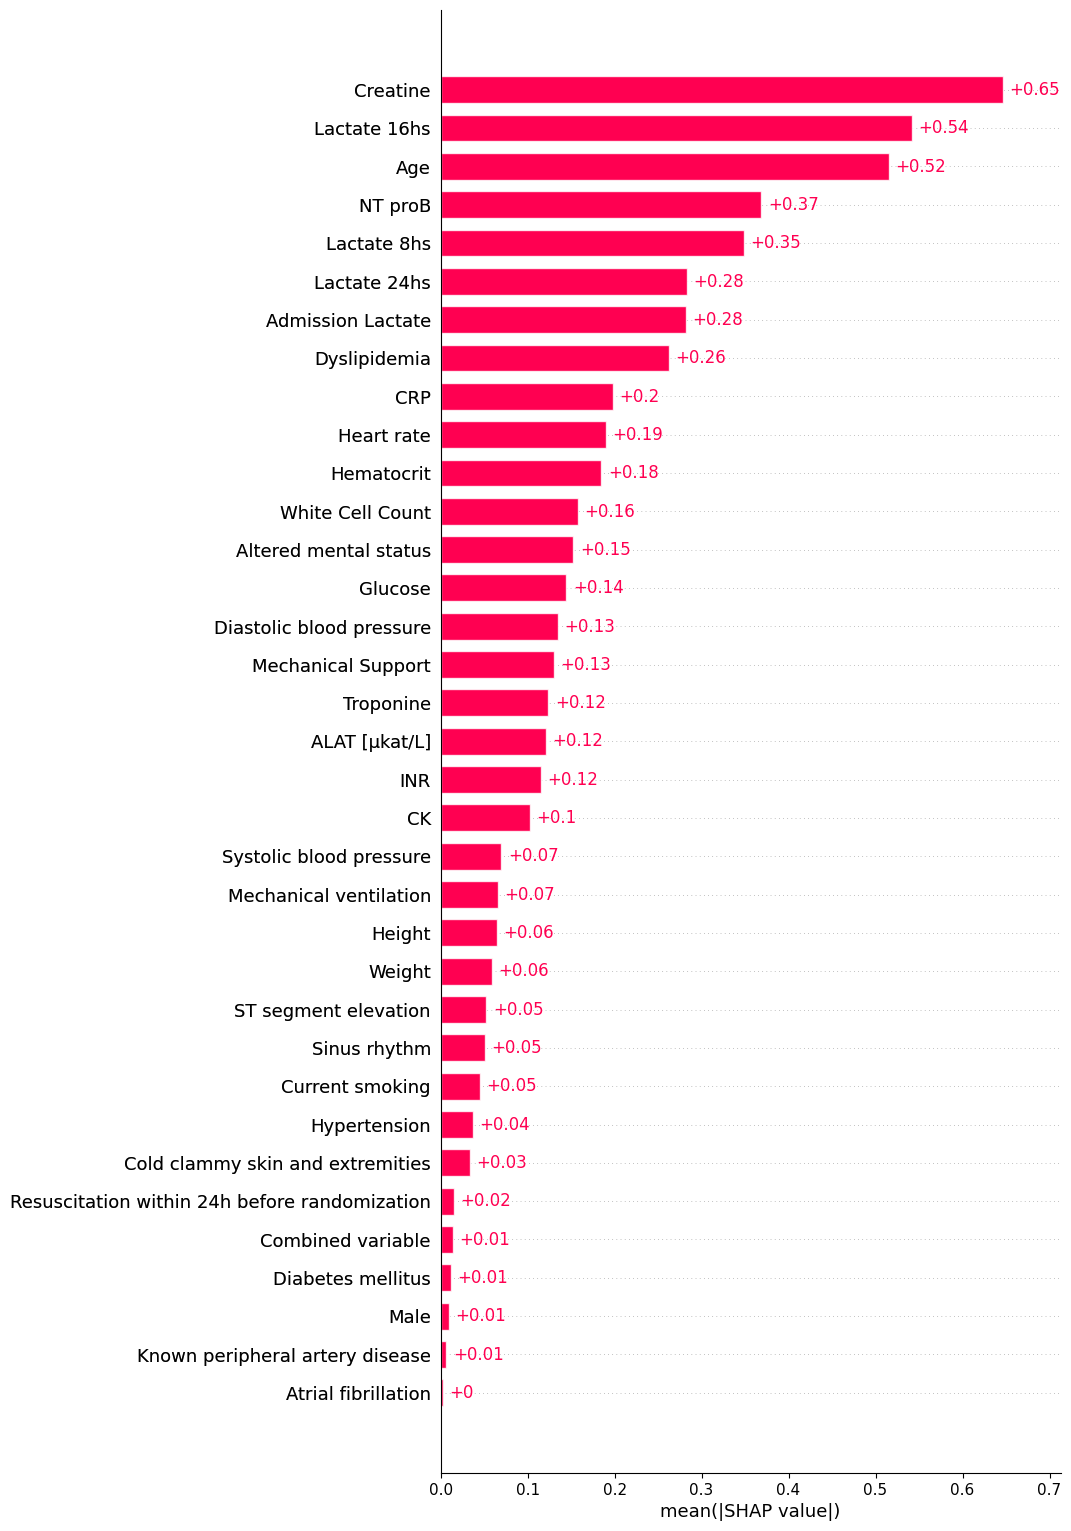

In [3]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/shap_values/"
load_list = ["shap_24hs_values",
             "shap_24hs_baseline",
             "shap_24hs_data"]
shap_dict = dict()

for file_name in load_list:
    with open(data_dir+file_name, "rb") as fp:
        shap_dict[file_name] = pickle.load(fp)
X_24 = pd.read_csv(data_dir+"X_24hs_v2.csv",index_col=0)


X_24.rename(columns={"Age_(year)": "Age",
                    "Heart_rate_(bpm)_Hemodinamics": "Heart rate",
                    "Diastolic_blood_pressure_(mmHg)_–_HPR":"Diastolic blood pressure",
                    "Height_(cm)": "Height",
                    "Weight_(kg)": "Weight",
                    'Mechanical_ventilation':'Mechanical ventilation',
                    "Resuscitation_within_24h_before_randomization": "Resuscitation within 24h before randomization",
                    "Altered_mental_status": "Altered mental status",
                    "Cold_clammy_skin_and_extremities": "Cold clammy skin and extremities",
                    "combined_variable": "Combined variable",
                    "Previous_congestive_heart_failure": "Previous congestive heart failure",
                    "Previous_stroke": "Previous stroke",
                    "Known_peripheral_artery_disease": "Known peripheral artery disease",
                    "Known_renal_insufficiency_(GFR_less_30_ml/min)": "Known renal insufficiency",
                    "Chronic_dialysis":"Chronic dialysis",
                    "Current_smoking": "Current smoking",
                    "Diabetes_mellitus": "Diabetes mellitus",
                    "Sinus_rhythm": "Sinus rhythm",
                    "Atrial_fibrillation": "Atrial fibrillation",
                    "AV-block_III": "AV block III",
                    'ST-segment_elevation':'ST segment elevation',
                    'Systolic_blood_pressure_(mmHg)_–_HPR':'Systolic blood pressure',
                    "Mechanical_Support":"Mechanical Support",
                    "Mild_induced_Hypothermia":"Mild induced Hypothermia",
                    "Renal_Replacement_Therapy":"Renal Replacement Therapy",
                    "Pre_PCI_Serum_lactate_value": "Pre PCI Lactate",
                    "Post_PCI_Serum_lactate_value": "Post PCI Lactate",
                    "Serum_lactate_value_8": "Lactate 8hs",
                    "Serum_lactate_value_16": "Lactate 16hs",
                    "Serum_lactate_value_24": "Lactate 24hs",
                    "No_reflow": "No reflow",
                    "Hematocrit_in_%": "Hematocrit",
                    "White_blood_cell_count_in_Gpt/L": "White blood cell count",
                    "HS_Troponin_I": "HS Troponin I",
                    "Procedural_success_(TIMI3_or_successful_complete_revascularization)": "Procedural success",
                    "ALAT_in_µkat/l": "ALAT [µkat/L]",
                    "GFR_CKD-EPI_creatinine_equation_V1_in_ml/min/1.73m²": "GFR Creatinine",
                    "NT_pro_B-type_natriuretic_peptide_V1_in_pg/ml": "NT proB",
                    "creatine": "Creatine",
                    "admission_lactate": "Admission Lactate",
                    "hematocrit": "Hematocrit",
                    "glucose": "Glucose",
                    "white_cell_count": "White Cell Count",
                    "resusitation_24hs": "Resucitation within 24hs",
                    "hs-Troponine_T_V1_in_pg/ml": "Troponine",
                    "C_Reaktive_Protein_V1_in_mg/l": "CRP",
                    "ALAT [µkat/L]": "ALAT"}, inplace=True)


model = joblib.load(data_dir+"model_24hs_v2_shap_values.pkl")

explainer = shap.Explainer(model)
shap_values = explainer(X_24)

shap_values.values = shap_dict["shap_24hs_values"]
shap_values.baseline = shap_dict["shap_24hs_baseline"]
shap_values.data = shap_dict["shap_24hs_data"]
shap.plots.bar(shap_values, max_display=50)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


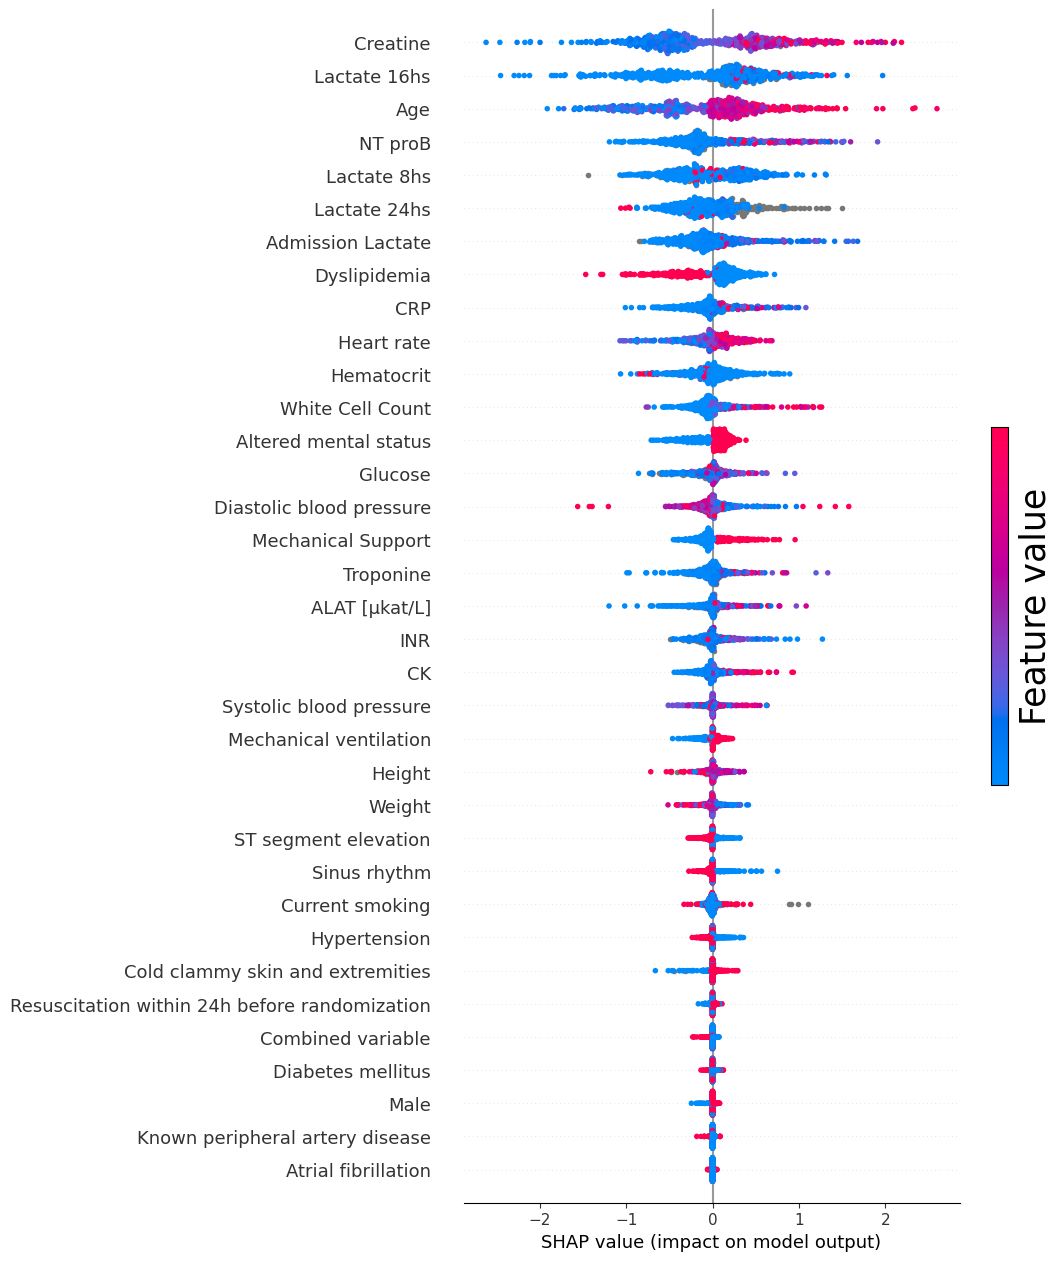

In [4]:
shap.plots.beeswarm(shap_values, color_bar=False, max_display=50,show=False)
plt.colorbar(location="right",label="Feature value", ticks=[], shrink=0.3)

# Missing values

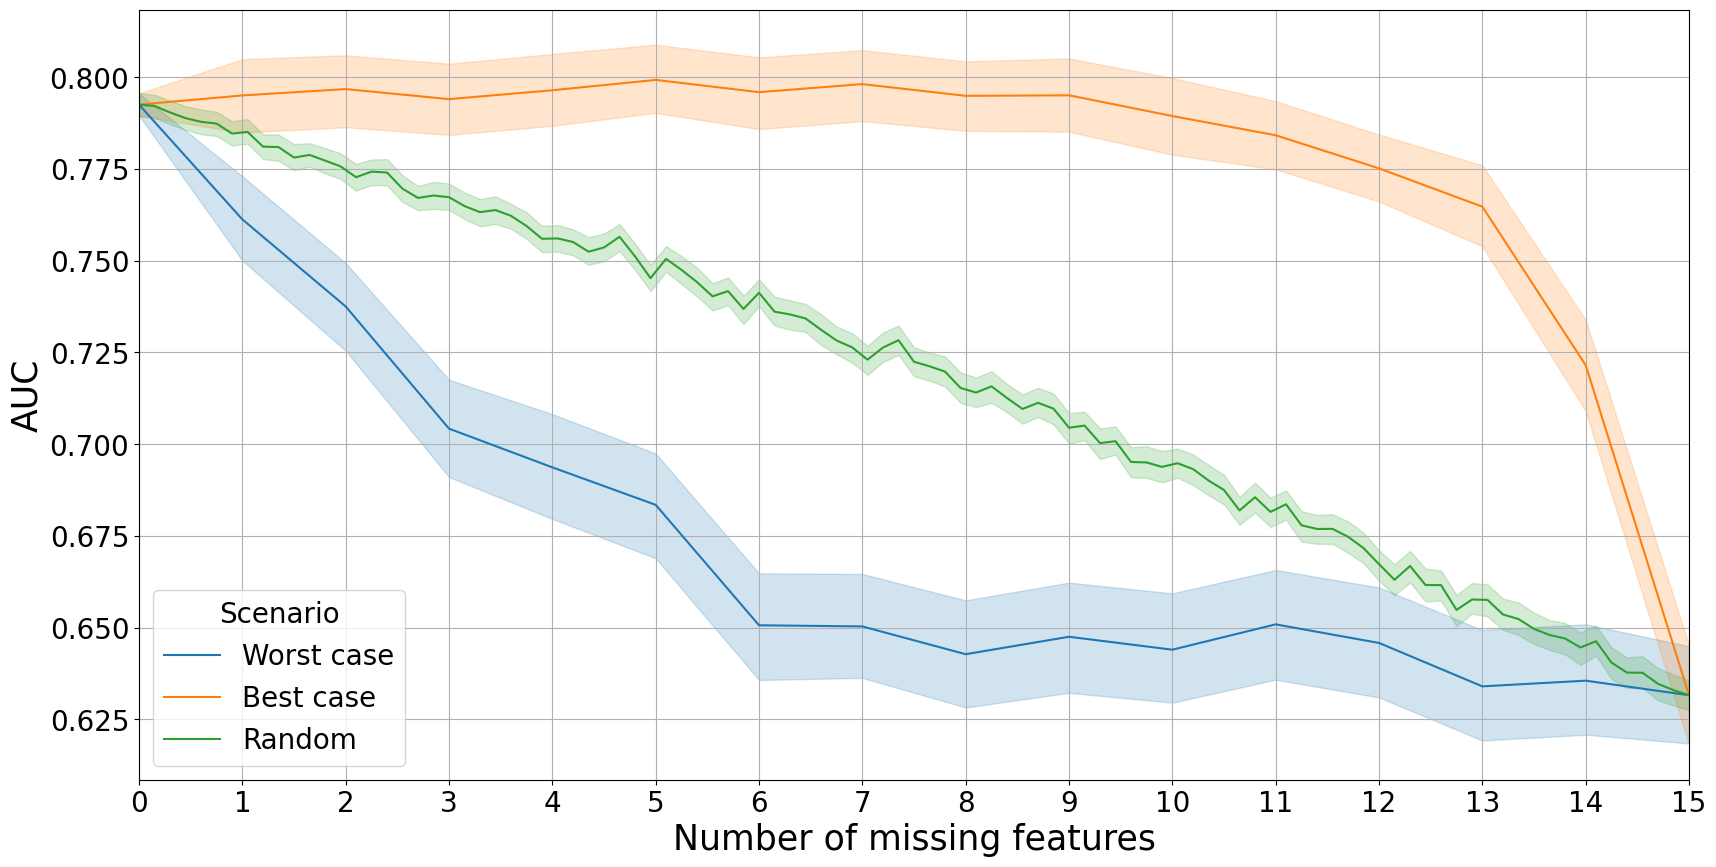

In [87]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/missing_values/"

results_random = pd.read_csv(data_dir + "missing_values_10foldx10repx10_shuffle.csv", index_col=0)
results_random["Percenage_nan"] = results_random["Percenage_nan"] * 15
results_random["Scenario"] = "Random"

results_0 = results_random[results_random["Percenage_nan"] == 0]

results_direct = pd.read_csv(data_dir + "missing_values_10foldx10rep_direct.csv", index_col=0)
results_direct["Percenage_nan"] = results_direct["Percenage_nan"] +1
results_direct = pd.concat([results_0,results_direct])
results_direct["Scenario"] = "Worst case"

results_inverse = pd.read_csv(data_dir + "missing_values_10foldx10rep_inverse.csv", index_col=0)

results_inverse["Percenage_nan"] = results_inverse["Percenage_nan"] + 1
results_inverse = pd.concat([results_inverse,results_0])
results_inverse["Scenario"] = "Best case"


fig, ax = plt.subplots(1, 1, figsize=[20, 10])
metric_to_plot = "AUC"
results_mv = pd.concat([results_direct,results_inverse,results_random])
results_mv_to_plot = results_mv[results_mv["Model"] == "24hs"]

sns.lineplot(
    data=results_mv_to_plot,
    x="Percenage_nan", y=metric_to_plot,
    hue="Scenario", ax=ax
)
plt.grid()
plt.xlim(0,15)
plt.xlabel("Number of missing features")
custom_ticks = np.arange(0, 16, 1)  # Range from 0 to 1 with step of 0.1
plt.xticks(custom_ticks)
# plt.title("Missing values impact in 24hs Model")
plt.show()

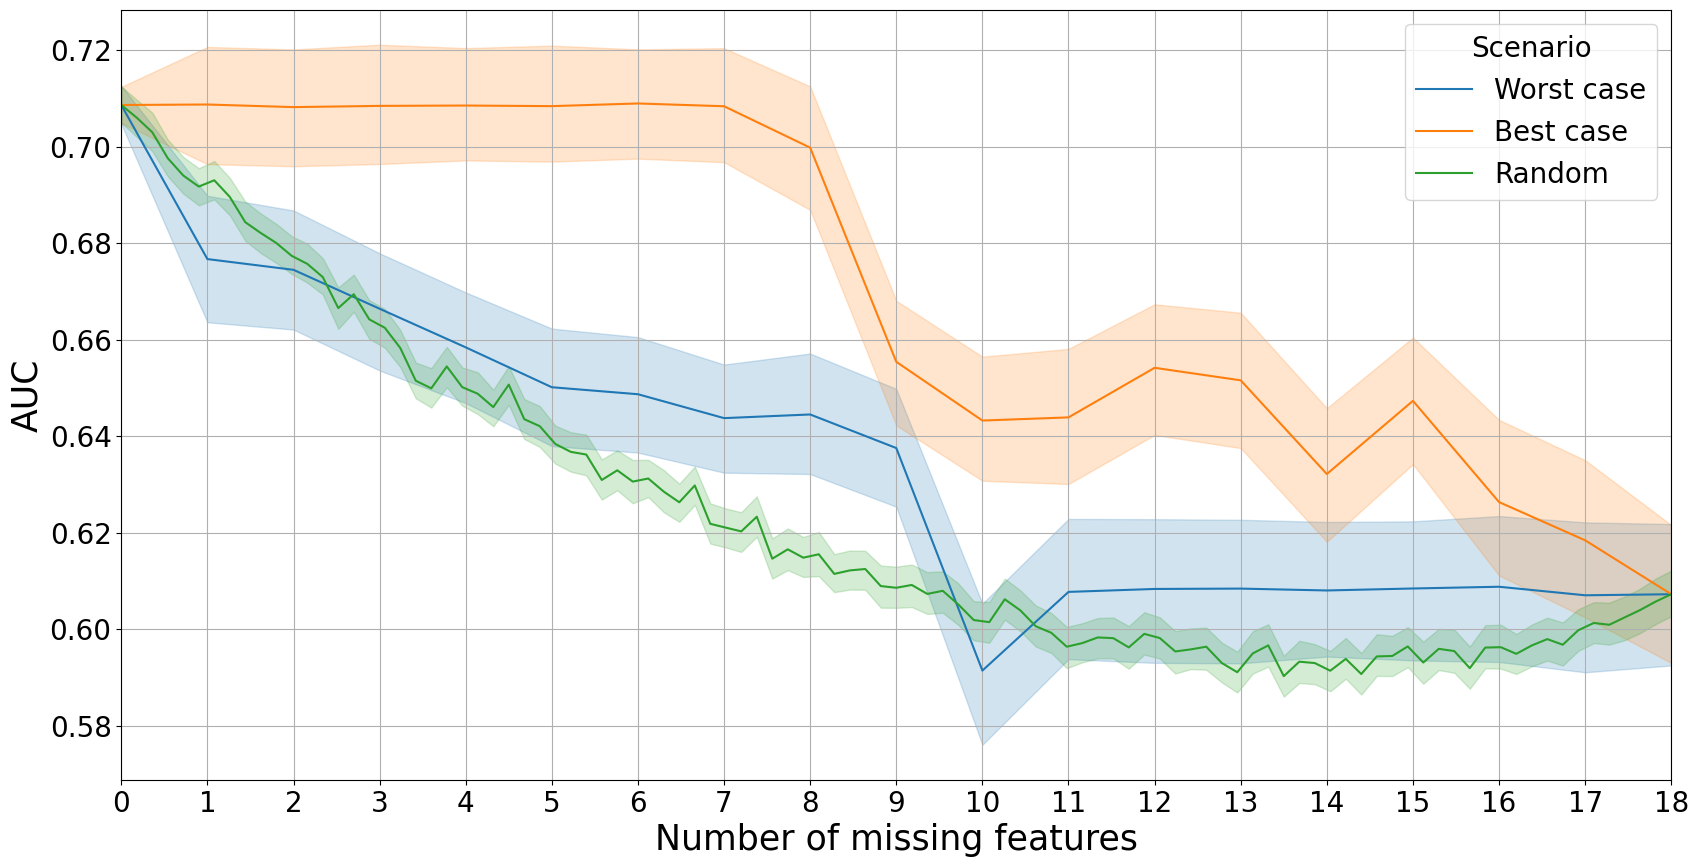

In [86]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/missing_values/"

results_random = pd.read_csv(data_dir + "missing_values_10foldx10repx10_shuffle_admission.csv", index_col=0)
results_random["Percenage_nan"] = results_random["Percenage_nan"] * 18
results_random["Scenario"] = "Random"

results_0 = results_random[results_random["Percenage_nan"] == 0]

results_direct = pd.read_csv(data_dir + "missing_values_10foldx10rep_direct_admission.csv", index_col=0)
results_direct["Percenage_nan"] = results_direct["Percenage_nan"] +1
results_direct = pd.concat([results_0,results_direct])
results_direct["Scenario"] = "Worst case"

results_inverse = pd.read_csv(data_dir + "missing_values_10foldx10rep_inverse_admission.csv", index_col=0)

results_inverse["Percenage_nan"] = results_inverse["Percenage_nan"] + 1
results_inverse = pd.concat([results_inverse,results_0])
results_inverse["Scenario"] = "Best case"


fig, ax = plt.subplots(1, 1, figsize=[20, 10])
metric_to_plot = "AUC"
results_mv = pd.concat([results_direct,results_inverse,results_random])
results_mv_to_plot = results_mv[results_mv["Model"] == "Admission"]

sns.lineplot(
    data=results_mv_to_plot,
    x="Percenage_nan", y=metric_to_plot,
    hue="Scenario", ax=ax
)
plt.grid()
plt.xlim(0,18)
plt.xlabel("Number of missing features")
custom_ticks = np.arange(0, 19, 1)  # Range from 0 to 1 with step of 0.1
plt.xticks(custom_ticks)
# plt.title("Missing values impact in Admission Model")ç
plt.show()

# Sensitivity trade off

The label '_none' of <matplotlib.collections.PolyCollection object at 0x7f71d82b1b80> starts with '_'. It is thus excluded from the legend.
The label '_none' of <matplotlib.collections.PolyCollection object at 0x7f71d82a58e0> starts with '_'. It is thus excluded from the legend.
The label '_none' of <matplotlib.collections.PolyCollection object at 0x7f71d82b5b80> starts with '_'. It is thus excluded from the legend.
The label '_none' of <matplotlib.collections.PolyCollection object at 0x7f71d8267a00> starts with '_'. It is thus excluded from the legend.


Text(0.5, 1.0, '24hs and CLIP score Sensitivity-Specificity analysis')

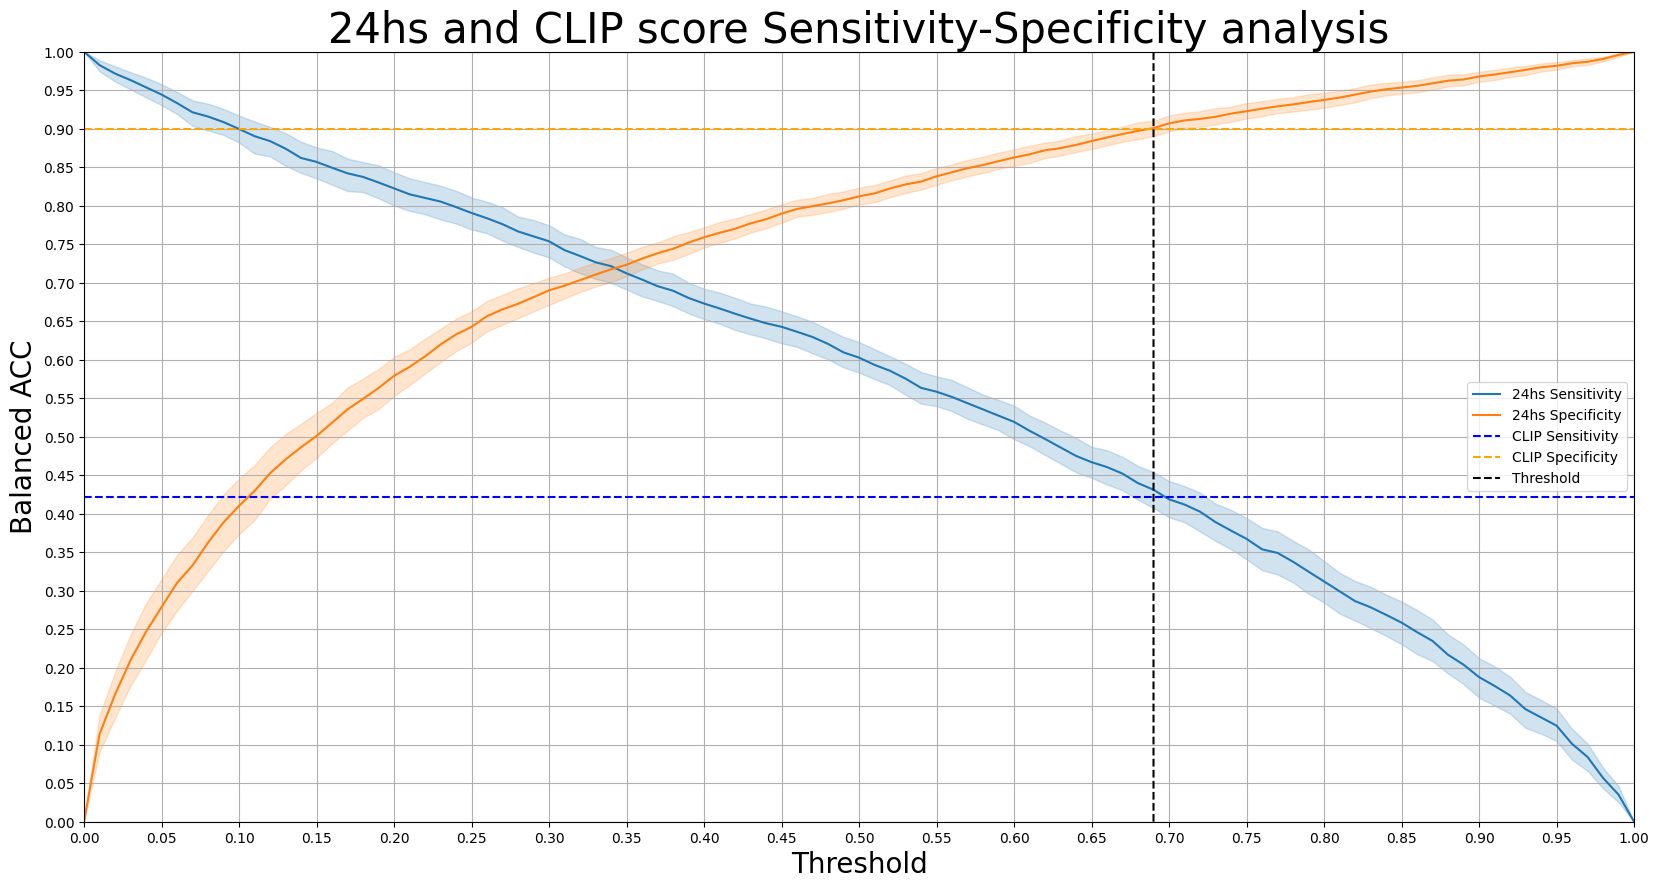

In [12]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/10x10/"
results_ths_df = pd.read_csv(data_dir + "threshold_10x10_24hs_v2.csv")

results_scores = pd.read_csv(data_dir + "metrics_10x10_true_and_random_labels_scores_v2.csv")
results_true_label = results_scores[results_scores["Random State"]==False]
fig, ax = plt.subplots(1, 1, figsize=[20, 10])
model_to_plot = "24hs"
results_ths_df_to_plot = results_ths_df[results_ths_df["Model"] == model_to_plot]   
sns.lineplot(data=results_ths_df_to_plot, y="Sensitivity", x="Threshold", legend=True, ax=ax)
sns.lineplot(data=results_ths_df_to_plot, y="Specificity", x="Threshold", legend=True, ax=ax)


model_to_compare = "CLIP_SCORE"
model_sensitivity = results_true_label[results_true_label["Model"] == model_to_compare]["Sensitivity"].mean()
model_specificity = results_true_label[results_true_label["Model"] == model_to_compare]["Specificity"].mean()
sns.lineplot(
    x=[0, 1], y=[model_sensitivity,                                                         
                 model_sensitivity], ax=ax, color="blue", linestyle="--", legend=True)
sns.lineplot(

    x=[0, 1], y=[model_specificity,                                                          
                 model_specificity], ax=ax, color="orange", linestyle="--", legend=True)

plt.grid()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel(metric_to_plot)
model_specificity = 0.69
sns.lineplot(
    x=[model_specificity-0.00001,  model_specificity], y=[0, 1], ax=ax, color="black", linestyle="--", legend=True)

plt.legend(["24hs Sensitivity","_none", "24hs Specificity", "_none",
            "CLIP Sensitivity","_none", "CLIP Specificity", "_none", "Threshold"])
custom_ticks = np.arange(0, 1.01, 0.05)  # Range from 0 to 1 with step of 0.1
plt.yticks(custom_ticks)
plt.xticks(custom_ticks)
plt.title("24hs and CLIP score Sensitivity-Specificity analysis")